# Day 1-2 measurements and sample discussion

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import mplhep as hep

from utils import angle_data
from utils.style import make_style
make_style()

from utils.angle_data import AngleData, SingleRun, get_data
# from utils import fresnel

from iminuit import Minuit, minuit

import glob 

Loading datasets

![](science.gif)

Angular distribution for normal incidence over photodiode


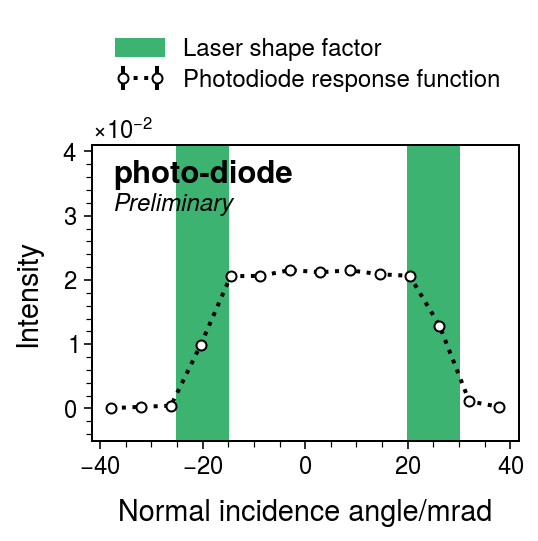

In [2]:
normal_dist_files = sorted(glob.glob('../data/normal_dist/**'))
nd_adl = get_data(normal_dist_files, 23)

nd_s1 = SingleRun(nd_adl)

center = nd_s1.angles.mean()
nd_s1.angles -= center
nd_s1.angles *= 1000

from scipy import integrate
integral = integrate.simpson(nd_s1.reflectance, dx=np.abs(nd_s1.angles[1]-nd_s1.angles[0]))
nd_s1.reflectance = nd_s1.reflectance/integral
nd_s1.reflectance_std /= integral

plt.figure(figsize=(3.75,2.55))

nd_s1.plot(marker='o:', legend='Photodiode response function')
plt.xlabel('Normal incidence angle/mrad')
plt.ylim(-0.005, 0.041)
hep.label.exp_text('photo-diode', 'Preliminary', loc=2, fontsize=12, italic=(False, True))
plt.ylabel('Intensity')

plt.axvspan(-25, -15, color='mediumseagreen', label='Laser shape factor')
plt.axvspan(20, 30, color='mediumseagreen')

plt.legend(loc=(0., 1.1), fontsize=12, numpoints=2)



plt.savefig('../figures/angle_spread.pdf', bbox_inches='tight')

In [3]:
Si_s_adl = get_data(sorted(glob.glob('../data/dataSi_0/**.lvm')), 23)
Si_p_adl = get_data(sorted(glob.glob('../data/dataSi_1/**.lvm')), 23)

p_Si = SingleRun(Si_p_adl, Si_p_adl[-1])
s_Si = SingleRun(Si_s_adl, Si_s_adl[-1])

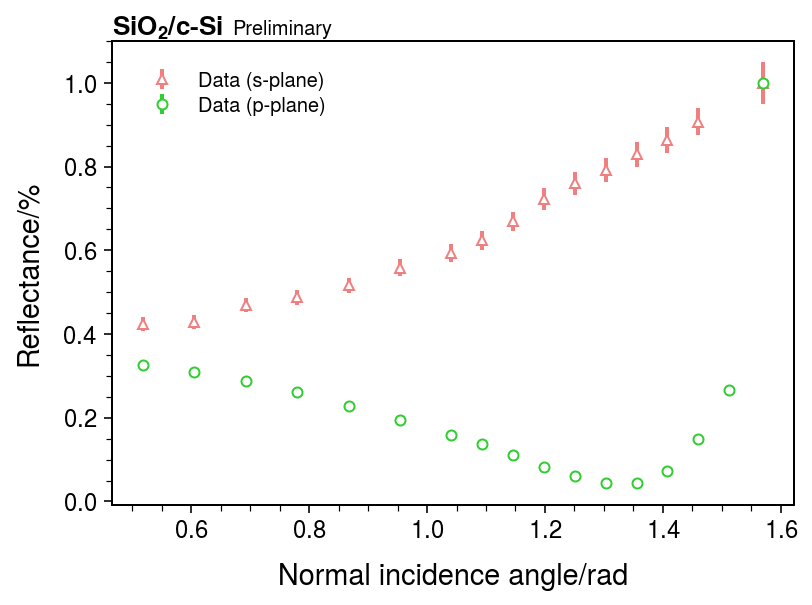

In [4]:








s_Si.plot(color='lightcoral', marker='^')
p_Si.plot(color='limegreen', marker='o')
hep.label.exp_text('SiO$\mathbf{_2}$/c-Si ', 'Preliminary')
plt.legend()

In [5]:
def r_12_p(theta, n1, n2):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n2 * np.cos(theta) - n1 * cos_theta2) / (n1 * cos_theta2 + n2 * np.cos(theta))
    )

def r_12_s(theta, n1, n2):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n1 * np.cos(theta) - n2 * cos_theta2) / (n1 * np.cos(theta) + n2 * cos_theta2)
    )

def r_23_p(theta, n1, n2, n3):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n3 * cos_theta2 - n2 * cos_theta3) / (n3 * cos_theta2 + n2 * cos_theta3)
    )

def r_23_s(theta, n1, n2, n3):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n2 * cos_theta2 - n3 * cos_theta3) / (n2 * cos_theta2 + n3 * cos_theta3)
    )
    
def phi(theta, ni, nt, d): 
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return 2 * np.pi * d * nt/ 532 * cos_transmitted
    
def construct_three_layer_r(r_al: callable, r_ls: callable, theta, n1, n2, n3, d):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    `n3`: complex refractive indices for material 3 (n = n + k*1j)
    `d` : inner layer width
    '''
    
    return (
        (r_al(theta, n1, n2) + r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))/
        (1 + r_al(theta, n1, n2) * r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))
    )


def Si_Rs(theta, n1, n2, n3, d, phase):
    rs_tot = construct_three_layer_r(r_12_s, r_23_s, theta - phase, n1, n2, n3, d)
    return np.abs( rs_tot * np.conj(rs_tot) )

def Si_Rp(theta, n1, n2, n3, d, phase):
    rp_tot = construct_three_layer_r(r_12_p, r_23_p, theta - phase, n1, n2, n3, d)
    return np.abs( rp_tot * np.conj(rp_tot) )


Appunti da ricordare: le formule per il multilayer sono da correggere perché $r_s$ e $r_p$ dipendono dagli angoli di incisione sull'interfaccia considerata e non sulla prima interfaccia

In [6]:
def fcn_Si(n1, k1, n2, k2, n3, k3, d, phase):
    cn1, cn2, cn3 = n1+k1*1j, n2+k2*1j, n3+k3*1j
    fcn = 0.0
    for x, y, std in zip(s_Si.angles, s_Si.reflectance, s_Si.reflectance_std):
        fcn += ((y - Si_Rs(x, cn1, cn2, cn3, d, phase)) / std)**2

    for x, y, std in zip(p_Si.angles, p_Si.reflectance, p_Si.reflectance_std):
        fcn += ((y - Si_Rp(x, cn1, cn2, cn3, d, phase)) / std)**2
    return fcn

n_Air  = 1.00027821
n_SiO2 = 1.4607
n_Si = 4.1360
k_Si = 0.010205

m_Si = Minuit(fcn_Si, n1=n_Air, k1=0.0, n2=n_SiO2, k2=0.0, n3=n_Si, k3=k_Si, d=2.5, phase=0)

# m_Si.limits['n1'] = (0.75, 1.15)
# m_Si.limits['k2'] = (0., 1.)
# m_Si.limits['k3'] = (0.001, 0.01)
m_Si.limits['n2'] = (1., 1.55)
m_Si.limits['n3'] = (2.25, 4.55)
m_Si.limits['k3'] = (0.001, 0.01)
m_Si.limits['d']  = (1., 3.)

m_Si.fixed['n1'] = True
# m_Si.fixed['n2'] = True
# m_Si.fixed['n3'] = True
m_Si.fixed['k1'] = True
m_Si.fixed['k2'] = True
# m_Si.fixed['k3'] = True

m_Si.migrad()
m_Si.hesse()
m_Si.migrad()
m_Si.hesse()
m_Si.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.621e+05                  │              Nfcn = 259              │
│ EDM = 6.38e-09 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n1    │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ k1    │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ n2    │ 1.550000  │ 0.000024  │            │            │    1    │  1.55   │       │
│ 3 │ k2    │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ n3    │  4.4625   │  0.0004   │            │            │  2.25   │  4.55   │       │
│ 5 │ k3    │ 10.000e-3 │ 0.007e-3  │            │            │  0.001  │  0.01   │       │
│ 6 │ d     │  3.00000  │  0.00005  │            │            │    1    │    3    │       │
│ 7 │ phase │ 1.399e-3  │ 0.023e-3  │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────┐
│       │        n1        k1        n2        k2        n3        k3         d     phase │
├───────┼─────────────────────────────────────────────────────────────────────────────────┤
│    n1 │         0         0         0         0         0         0         0         0 │
│    k1 │         0         0         0         0         0         0         0         0 │
│    n2 │         0         0  2.19e-21         0   6.6e-19 -6.11e-28 -2.75e-26  2.16e-20 │
│    k2 │         0         0         0         0         0         0         0         0 │
│    n3 │         0         0   6.6e-19         0  1.83e-07  2.67e-19   1.1e-17 -3.74e-09 │
│    k3 │         0         0 -6.11e-28         0  2.67e-19  6.75e-23  3.75e-27  1.54e-21 │
│     d │         0         0 -2.75e-26         0   1.1e-17  3.75e-27   4.8e-20 -1.13e-19 │
│ phase │         0         0  2.16e-20         0 -3.74e-09  1.54e-21 -1.13e-19   5.4e-10 │
└───────┴─────────────────────────────────────────────────────────────────────────────────┘

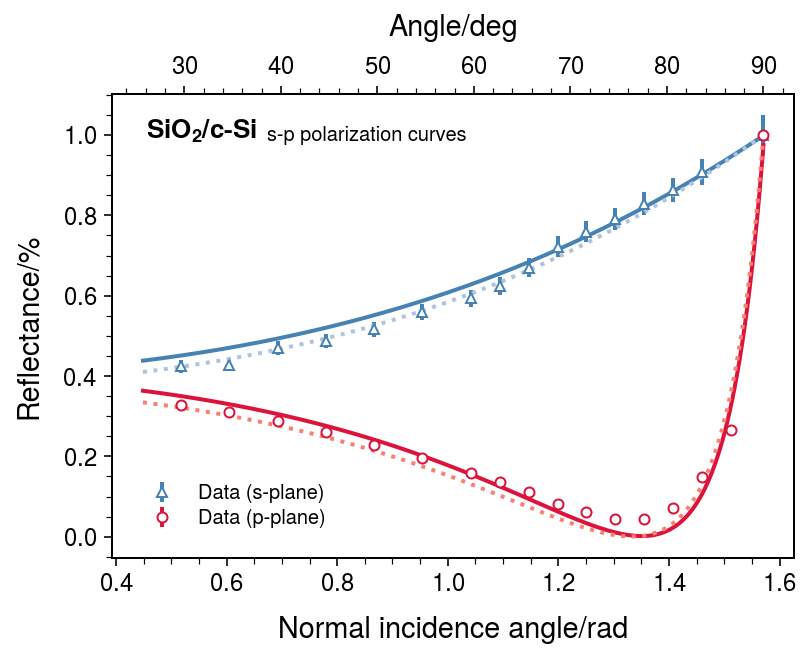

In [7]:
s_color = 'steelblue'
p_color = 'crimson'

s_Si.plot(color=s_color, marker='^')
p_Si.plot(color=p_color, marker='o')

angles = np.linspace(np.pi/7, np.pi/2, 500)
n1,k1,n2,k2,n3,k3,d,phase = m_Si.values

# FIT
plt.plot(angles, Si_Rs(angles, n1+k1*1j, n2+k2*1j, n3+k3*1j, d, phase), color=s_color)
plt.plot(angles, Si_Rp(angles, n1+k1*1j, n2+k2*1j, n3+k3*1j, d, phase), color=p_color)

# THEORY
plt.plot(angles, Si_Rs(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2, 0), color='lightsteelblue', ls=':')
plt.plot(angles, Si_Rp(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2, 0), color='salmon', ls=':')


hep.label.exp_text('SiO$\mathbf{_2}$/c-Si ', 's-p polarization curves',loc=1)
ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')
plt.legend(loc=3)
plt.savefig('../figures/c_Si_Rs_Rp.pdf', bbox_inches='tight')

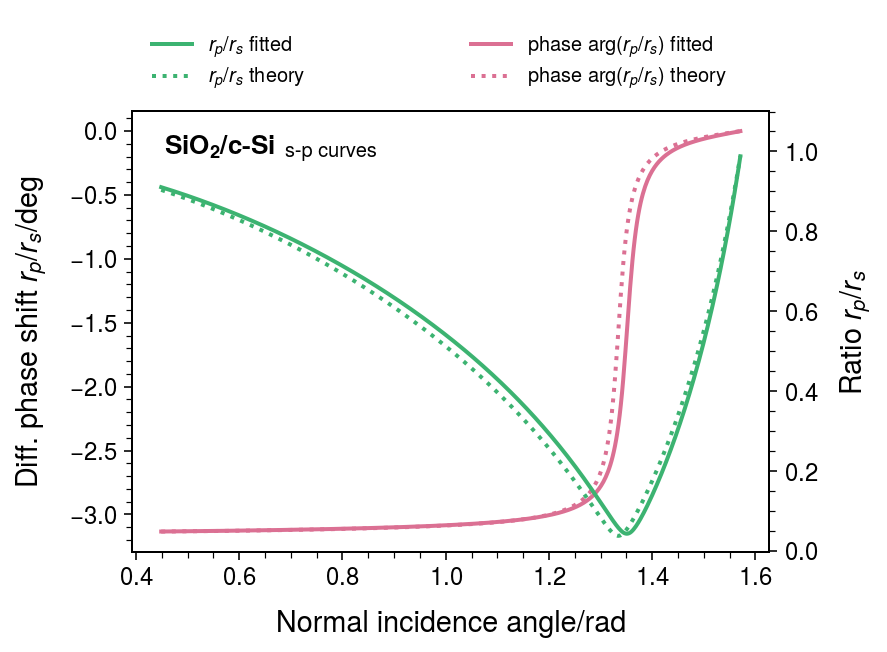

In [8]:
rs_rp_fit = construct_three_layer_r(r_12_p, r_23_p, angles - phase, n1, n2, n3, d) / construct_three_layer_r(r_12_s, r_23_s, angles - phase, n1, n2, n3, d)
rs_rp_phase_fit = np.angle(rs_rp_fit)
rs_rp_abs_fit = np.abs(rs_rp_fit)
rs_rp_theo = construct_three_layer_r(r_12_p, r_23_p, angles - phase, n_Air, n_SiO2, n_Si+1j*k_Si, d) / construct_three_layer_r(r_12_s, r_23_s, angles - phase, n_Air, n_SiO2, n_Si+1j*k_Si, d)
rs_rp_phase_theo = np.angle(rs_rp_theo)
rs_rp_abs_theo = np.abs(rs_rp_theo)

plt.figure(figsize=(5.6, 3.8))

plt.plot(angles, rs_rp_phase_fit, 'palevioletred', label=r'phase $\arg(r_p/r_s)$ fitted')
plt.plot(angles, rs_rp_phase_theo, 'palevioletred', ls=':', label=r'phase $\arg(r_p/r_s)$ theory')
plt.legend(loc=(0.5, 1.0))
plt.xlabel('Normal incidence angle/rad')
plt.ylabel('Diff. phase shift $r_p/r_s$/deg')

hep.label.exp_text('SiO$\mathbf{_2}$/c-Si ', 's-p curves',loc=1)
ax = plt.gca()

ax2 = ax.twinx()
ax2.plot(angles, rs_rp_abs_fit, 'mediumseagreen', label=r'$r_p/r_s$ fitted')
ax2.plot(angles, rs_rp_abs_theo, 'mediumseagreen', ls=':', label=r'$r_p/r_s$ theory')
ax2.set_ylabel('Ratio $r_p/r_s$')
ax2.legend(loc=(0., 1.0))
ax2.set_ylim(-0.001,1.101)
plt.savefig('../figures/phase_ratio_Air.SiO2.Si.pdf', bbox_inches='tight')

Analyzing Au data

In [9]:
Au_s_adl = get_data(sorted(glob.glob('../data/dataAu_0/**.lvm')), 23)
Au_p_adl = get_data(sorted(glob.glob('../data/dataAu_1/**.lvm')), 23)

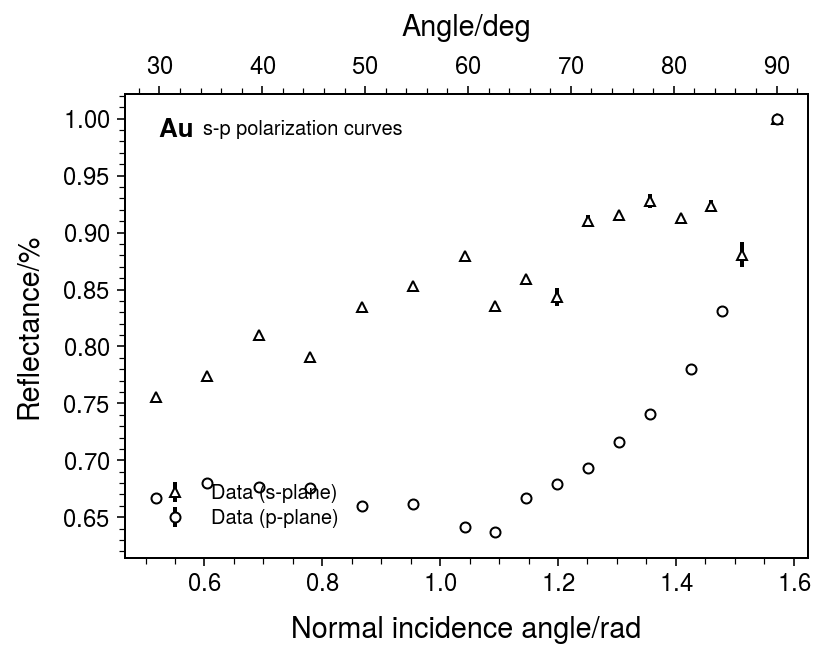

In [10]:
s_Au = SingleRun(Au_s_adl, Au_s_adl[-1])
p_Au = SingleRun(Au_p_adl, Au_p_adl[-1])
s_Au.plot(marker='^')
p_Au.plot()

ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')

hep.label.exp_text('Au ', 's-p polarization curves', loc=1)
plt.legend(loc=3)

In [11]:
def r_p(theta, ni, nt):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (nt * np.cos(theta) - ni * cos_transmitted) / (ni * cos_transmitted + nt * np.cos(theta))
    )

def r_s(theta, ni, nt):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (ni * np.cos(theta) - nt * cos_transmitted) / (ni * np.cos(theta) + nt * cos_transmitted)
    )

def Au_Rs(theta, n1, n2, phase):
    rs = r_s(theta-phase, n1, n2)
    return np.abs( rs * np.conj(rs) )

def Au_Rp(theta, n1, n2, phase):
    rp = r_p(theta-phase, n1, n2)
    return np.abs( rp * np.conj(rp) )

In [12]:
def fcn_Au(n1, k1, n2, k2, phase):
    fcn = 0.0
    for x, y, std in zip(s_Au.angles, s_Au.reflectance, s_Au.reflectance_std):
        fcn += ((y - Au_Rs(x, n1+k1*1j, n2+k2*1j, phase)) / std)**2
    for x, y, std in zip(p_Au.angles, p_Au.reflectance, p_Au.reflectance_std):
        fcn += ((y - Au_Rp(x, n1+k1*1j, n2+k2*1j, phase)) / std)**2
    return fcn

n_Air  = 1.00027821
n_Au   = 0.54463
k_Au   = 2.1406

m_Au = Minuit(fcn_Au, n1=n_Air, k1=0, n2=n_Au, k2=k_Au, phase=0)

m_Au.fixed['n1']=True
m_Au.fixed['k1']=True

m_Au.migrad()
m_Au.hesse()
m_Au.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2116                       │              Nfcn = 136              │
│ EDM = 3.12e-13 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n1    │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ k1    │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ n2    │  0.3233   │  0.0029   │            │            │         │         │       │
│ 3 │ k2    │   1.750   │   0.011   │            │            │         │         │       │
│ 4 │ phase │  0.0200   │  0.0015   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │        n1        k1        n2        k2     phase │
├───────┼───────────────────────────────────────────────────┤
│    n1 │         0         0         0         0         0 │
│    k1 │         0         0         0         0         0 │
│    n2 │         0         0  8.54e-06  3.26e-05 -2.54e-06 │
│    k2 │         0         0  3.26e-05   0.00013 -8.72e-06 │
│ phase │         0         0 -2.54e-06 -8.72e-06  2.38e-06 │
└───────┴───────────────────────────────────────────────────┘

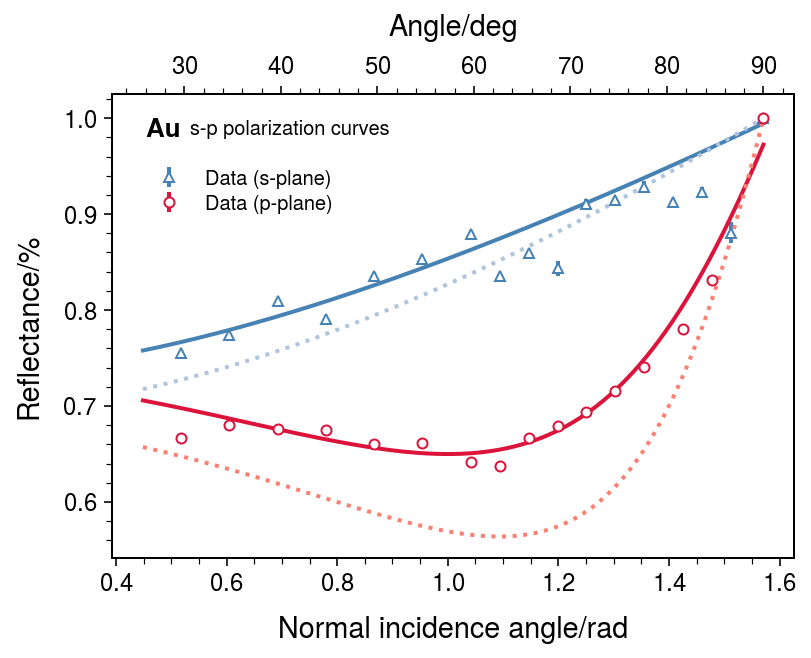

In [13]:
s_Au.plot(marker='^', color=s_color)
p_Au.plot(color=p_color)

hep.label.exp_text('Au ', 's-p polarization curves', loc=1)

n1,k1,n2,k2,phase = m_Au.values
plt.plot(angles, Au_Rs(angles, n1+k1*1j, n2+k2*1j, phase), color=s_color)
plt.plot(angles, Au_Rp(angles, n1+k1*1j, n2+k2*1j, phase), color=p_color)

plt.plot(angles, Au_Rs(angles, n_Air, n_Au+k_Au*1j,0), color='lightsteelblue', ls=':')
plt.plot(angles, Au_Rp(angles, n_Air, n_Au+k_Au*1j,0), color='salmon', ls=':')

ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')

plt.legend(loc=(0.025, 0.7))
plt.savefig('../figures/Au_Rs_Rp.pdf', bbox_inches='tight')

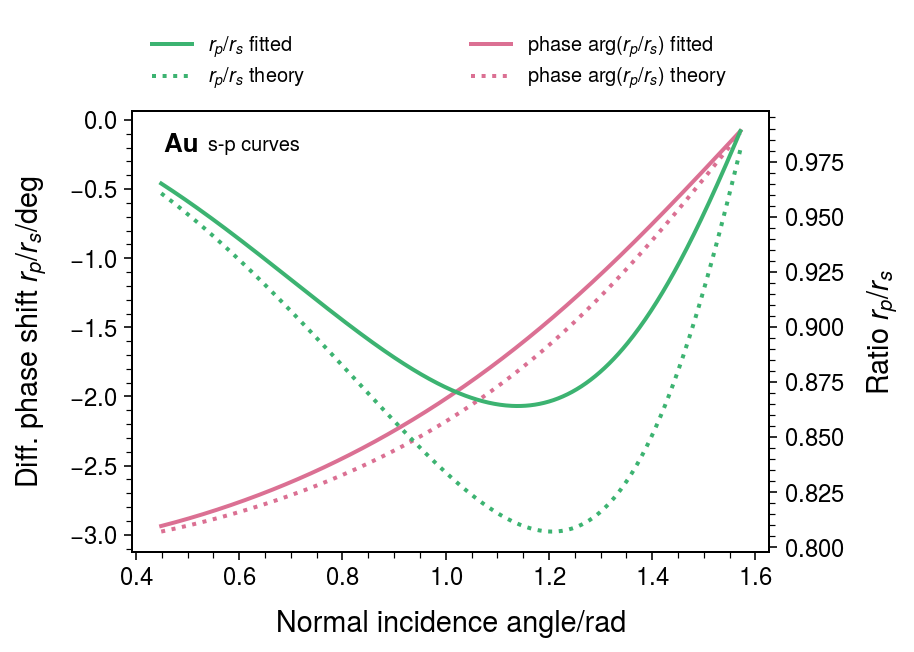

In [14]:
rs_rp_fit = r_p(angles - phase, n1, n2+1j*k2) / r_s(angles - phase, n1, n2+1j*k2)
rs_rp_phase_fit = np.angle(rs_rp_fit)
rs_rp_abs_fit = np.abs(rs_rp_fit)
rs_rp_theo = r_p(angles - phase, n_Air, n_Au+1j*k_Au) / r_s(angles - phase, n_Air, n_Au+1j*k_Au)
rs_rp_phase_theo = np.angle(rs_rp_theo)
rs_rp_abs_theo = np.abs(rs_rp_theo)

plt.figure(figsize=(5.6, 3.8))
plt.plot(angles, rs_rp_phase_fit, 'palevioletred', label=r'phase $\arg(r_p/r_s)$ fitted')
plt.plot(angles, rs_rp_phase_theo, 'palevioletred', ls=':', label=r'phase $\arg(r_p/r_s)$ theory')
plt.legend(loc=(0.5, 1.0))
plt.xlabel('Normal incidence angle/rad')
plt.ylabel('Diff. phase shift $r_p/r_s$/deg')

hep.label.exp_text('Au ', 's-p curves',loc=1)
ax = plt.gca()

ax2 = ax.twinx()
ax2.plot(angles, rs_rp_abs_fit, 'mediumseagreen', label=r'$r_p/r_s$ fitted')
ax2.plot(angles, rs_rp_abs_theo, 'mediumseagreen', ls=':', label=r'$r_p/r_s$ theory')
ax2.set_ylabel('Ratio $r_p/r_s$')
ax2.legend(loc=(0., 1.0))
# ax2.set_ylim(-0.001,1.101)
plt.savefig('../figures/phase_ratio_Air.Au.pdf', bbox_inches='tight')